---
title: "data splitting"
execute:
  # echo: false
  freeze: auto  # re-render only when source changes
format:
  html:
    code-fold: true
    code-summary: "Show the code"
---

<br>
<div class="alert alert-danger">
**"Past performance is not indicative of future results."**</div>

Every investment firm has this disclaimer. Although it is generally very good practice not to heavily rely on any particularly successful hedgefund to take care of my business, I still find this sentence infuriating. If past performance is not indicative, then stop advertising last year's returns! What's more, how should I decide to whom entrust my investments (if at all) if a firm's track record is "not indicative"?!

This chapter deals with the central idea of model generalization. We've seen enough examples from the previous chapters on [bias-variance tradeoff](/generalization/bias-variance-tradeoff.ipynb), [overfitting and underfitting](/generalization/overfitting-and-underfitting.ipynb), and [cross-validation](/generalization/cross-validation.ipynb) to discuss head on the question of "what is it all good for?"

## what is it all good for?

I will stipulate that the one question important to us is:

**How can I study a system's past behavior, so I can say something meaningful about its future?**

There are many other interesting questions that I could have asked, but if you are with me that right now we will focus on the question above only, then there are many things that we should and should not do.

Data splitting, the name of this chapter, is a technical term, and we might think that it primarily deals with rules of thumb like splitting our dataset 70-30% between training and test sets. We can learn all that in other tutorials, not here. I will argue that data-splitting best practices are there to ensure the integrity of the question above.


## NOT splitting the data

Let's say that I conducted an experiment and collected 30 data points.

In [141]:
#| code-summary: "import libraries"
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks", font_scale=1.2)
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from numpy.polynomial import Chebyshev
import statsmodels.api as sm
from sklearn.metrics import r2_score, mean_squared_error

blue = "xkcd:cerulean"
gold = "xkcd:gold"
pink = "xkcd:hot pink"
green = "xkcd:forest"
purple = "xkcd:barney"

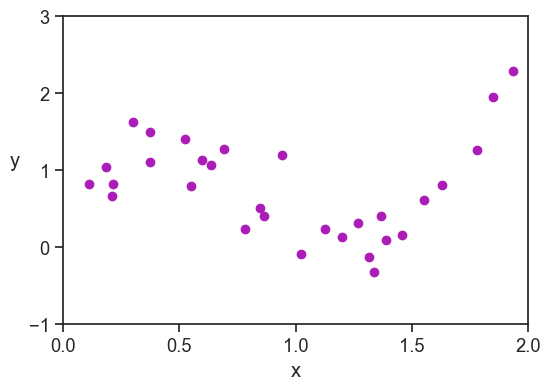

In [111]:
#| code-summary: "plot sample data"
xp = np.linspace(0, 2, 4)
yp = np.array([0, 1, 0, 3])
coefficients = np.polyfit(xp, yp, deg=3)
polynomial = np.poly1d(coefficients)
N = 30
rng = np.random.default_rng(seed=2)
sample_x = rng.uniform(0, 2, size=N)
noise = rng.normal(0, 0.3, size=N)
sample_y = polynomial(sample_x) + noise
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sample_x, sample_y, "o", color=purple, label="sample data")
ax.set(xlabel="x",
       xlim=(0, 2),
       ylim=(-1, 3),
       xticks=np.arange(0, 2.5, 0.5),
       yticks=np.arange(-1, 4, 1))
ax.set_ylabel("y", rotation=0, labelpad=10);

I now develop a model to explain the data, and decide to fit a degree 2 polynomial (a parabola) to the data:

Best fit parabola: y = 1.5x^2 -3.0x + 1.9
Adjusted R^2: 0.36
RMSE: 0.51
p-value for positive x^2 coefficient: 0.0001


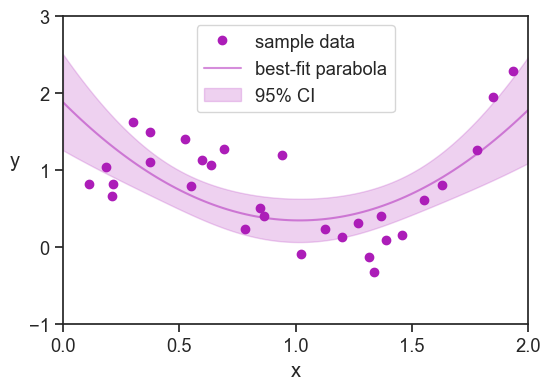

In [127]:
#| code-summary: "sample data and degree 2 polynomial fit"
def quadratic_design_matrix(x):
    X = np.column_stack((x, x**2))
    X = sm.add_constant(X) # Adds the intercept (beta_0)
    return X

sample_X = quadratic_design_matrix(sample_x)
model = sm.OLS(sample_y, sample_X).fit()
fitted_params = model.params
p_values_params = model.pvalues
grid_x = np.linspace(0, 2, 100)
grid_X = quadratic_design_matrix(grid_x)
prediction_obj_grid = model.get_prediction(grid_X)
summary_frame = prediction_obj_grid.summary_frame(alpha=0.05)
y_mean = summary_frame['mean']
y_low  = summary_frame['mean_ci_lower']
y_high = summary_frame['mean_ci_upper']


fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sample_x, sample_y, "o", color=purple, label="sample data")

residual_squared = (sample_y - model.predict(sample_X))**2
SS_residual = np.sum(residual_squared)
SS_total = np.sum((sample_y - np.mean(sample_y)) ** 2)
R2 = 1 - SS_residual / SS_total
# RMSE = np.sqrt(np.mean(residual_squared))
R2 = model.rsquared
adj_R2 = model.rsquared_adj
RMSE = np.sqrt(model.mse_resid)

fit_label = fr"$y = {fitted_params[2]:.1f}x^2$" + fr"${fitted_params[1]:.1f}x + {fitted_params[0]:.1f}$"+"\n"+ fr"$adj R^2 = {adj_R2:.2f}$, RMSE$ = {RMSE:.2f}$"
best_fit_parabola = f"y = {fitted_params[2]:.1f}x^2 {fitted_params[1]:.1f}x + {fitted_params[0]:.1f}"
ax.plot(grid_x, y_mean, "-", color=purple, alpha=0.5, label="best-fit parabola")
ax.fill_between(grid_x, y_low, y_high, color=purple, alpha=0.2, label="95% CI")
ax.legend(loc="upper center", frameon=True)
ax.set(xlabel="x",
       xlim=(0, 2),
       ylim=(-1, 3),
       xticks=np.arange(0, 2.5, 0.5),
       yticks=np.arange(-1, 4, 1))
ax.set_ylabel("y", rotation=0, labelpad=10);
print("Best fit parabola: "+ best_fit_parabola)
print(f"Adjusted R^2: {adj_R2:.2f}")
print(f"RMSE: {RMSE:.2f}")
print(f"p-value for positive x^2 coefficient: {p_values_params[2]/2:.4f}")

Here are a few things I could say about my findings:

* The model explains 36% of the variance in the sample data.
* The model's performance, as measured by the root mean squared error against the sample data, is 0.51.
* The sample data is best explained by a convex parabola (positive coefficient for the $x^2$ term), and the p-value for this coefficient is 0.0001 (against the null hypothesis of a zero coefficient).

All of this is fine, and I made sure to say "sample data" in all of the statements above. If all I'm interested is in describing the past, then all is good.

I might be tempted to say something more general, like:

* The model captures 36% of the variance in this **system**.
* We can **predict** the system's behavior with an expected RMSE of 0.51.
* We demonstrate that **variable** $y$ has a convex relationship with **variable** $x$.

This is where we are in trouble. We have no reason to believe that the model's **performance** on the sample data will be similar to its performance on future data from the same system.
More generally, we have no reason to believe that the **relationship** between $y$ and $x$ in the sample data will be similar to the relationship between $y$ and $x$ in future data from the same system.
It could be so, we just don't know it.

And why not? Because we **optimized** the model to fit the sample data, and we never tested the model on data it hasn't seen before. This simple fact prevents us from generalizing our findings to the system as a whole, and to future data from the system.

The conclusion here is that if we want to say something meaningful about the system in general, or about its future, then we **need** to put aside some of the data.

## performance on unseen data

In general terms, we expect that the a model's performance on unseen data will be worse than its performance on the data it was trained on. The reason should be obvious to us from now on: we **optimized** the model to fit the training data. Sure, it could be that by chance the performance on the unseen data is better than on the training data, but we have no reason to expect it.

As an illustration, let's say that we split our sample data of 30 points into a training set of 20 and a test set of 10. We fit the same degree 2 polynomial to the training data, and evaluate its performance on the test data.

In [ ]:
train_x = sample_x[:20]
train_y = sample_y[:20]
test_x = sample_x[20:]
test_y = sample_y[20:]

train_X = quadratic_design_matrix(train_x)
test_X = quadratic_design_matrix(test_x)
model = sm.OLS(train_y, train_X).fit()
fitted_params = model.params
p_values_params = model.pvalues
prediction_obj_grid = model.get_prediction(grid_X)
summary_frame = prediction_obj_grid.summary_frame(alpha=0.05)
y_mean = summary_frame['mean']
y_low  = summary_frame['mean_ci_lower']
y_high = summary_frame['mean_ci_upper']

# 1. Generate predictions for both sets
preds_train = model.predict(train_X)
preds_test = model.predict(test_X)

# 2. Calculate RMSE
# Note: np.sqrt(mean_squared_error(...)) gives the "plug-in" RMSE (divided by n)
rmse_train = np.sqrt(mean_squared_error(train_y, preds_train))
rmse_test = np.sqrt(mean_squared_error(test_y, preds_test))

# 3. Calculate R2
r2_train = r2_score(train_y, preds_train)
r2_test = r2_score(test_y, preds_test)

print(f"Train: R2 = {r2_train:.4f}, RMSE = {rmse_train:.4f}")
print(f"Test:  R2 = {r2_test:.4f},  RMSE = {rmse_test:.4f}")

Train: R2 = 0.5363, RMSE = 0.4347
Test:  R2 = -0.0553,  RMSE = 0.5876


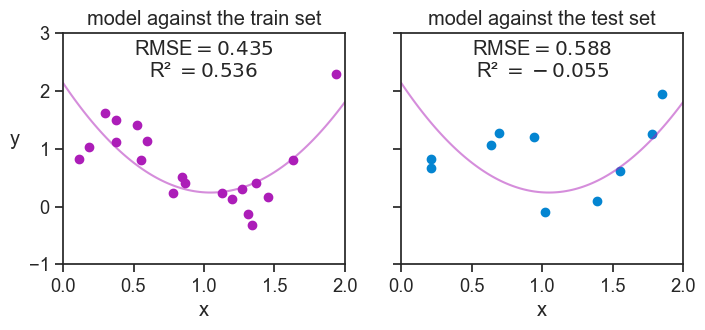

In [153]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3), sharey=True)

ax[0].plot(train_x, train_y, "o", color=purple, label="train set")
ax[0].plot(grid_x, y_mean, "-", color=purple, alpha=0.5, label="best-fit parabola")
# prediction_obj_grid = model.get_prediction(grid_X)

ax[1].plot(test_x, test_y, "o", color=blue, label="test data")
ax[1].plot(grid_x, y_mean, "-", color=purple, alpha=0.5, label="best-fit parabola")

ax[0].text(0.5, 0.97, fr"RMSE$ = {rmse_train:.3f}$"+"\n"+fr"R² $= {r2_train:.3f}$", transform=ax[0].transAxes,
           horizontalalignment='center', verticalalignment='top',)
ax[1].text(0.5, 0.97, fr"RMSE$ = {rmse_test:.3f}$"+"\n"+fr"R² $= {r2_test:.3f}$", transform=ax[1].transAxes,
           horizontalalignment='center', verticalalignment='top',)
ax[0].set(xlabel="x",
          xlim=(0, 2),
          ylim=(-1, 3),
          xticks=np.arange(0, 2.5, 0.5),
          yticks=np.arange(-1, 4, 1),
          title="model against the train set")
ax[0].set_ylabel("y", rotation=0, labelpad=10)
ax[1].set(xlabel="x",
          xlim=(0, 2),
          ylim=(-1, 3),
          xticks=np.arange(0, 2.5, 0.5),
          yticks=np.arange(-1, 4, 1),
          title="model against the test set");


As expected, the model's performance on the test data, as measured by the RMSE and R-squared, is worse than its performance on the training data: the RMSE went up, and the R-squared went down. By chance, we had the "luck" of getting a negative R-squared on the test data! How is that possible?! In very few words, this means that the model is worse that useless. The model does so badly on the test data, that we would have been better off just predicting the mean of the test data for all test points, instead of using the model's predictions. More on this point on the chapter on [R-squared](/regression/R-squared.ipynb).

## target leakage

This is when features contain information that would not be available at prediction time — e.g., including the answer or something correlated with the answer into the model. The result is overly optimistic performance that will not repeat in new data.

You can show a simple synthetic example where a “feature” directly encodes the target (say, with added noise) and then the evaluation looks good but fails on truly unseen data.

## train–test contamination

This is when the test set ends up influencing the model, often through improper preprocessing. Common examples include:

scaling using global mean & std instead of training mean & std

feature selection done before splitting

shuffling time series data and randomly splitting despite temporal order

All of these are examples where information from the test set leaks into training.

A simple demonstration can be:

Fit a model with normalization applied to the whole dataset, then compare its test performance to the same model with normalization done properly only on training data.

That produces two curves where the first looks unrealistically good.

<!-- Core question

Where does prediction error come from?

Main goal

Make bias and variance visible, not operational.

Topics to cover

synthetic data from a known function

repeated datasets (or resampling)

polynomial fits of varying degree

averaging predictions at fixed x

visualization of:

mean prediction (bias)

spread of predictions (variance)

conceptual error decomposition (no heavy math) -->

WRONG pipeline (feature selection before split)
Test accuracy: 0.979

CORRECT pipeline (split before feature selection)
Test accuracy: 0.500



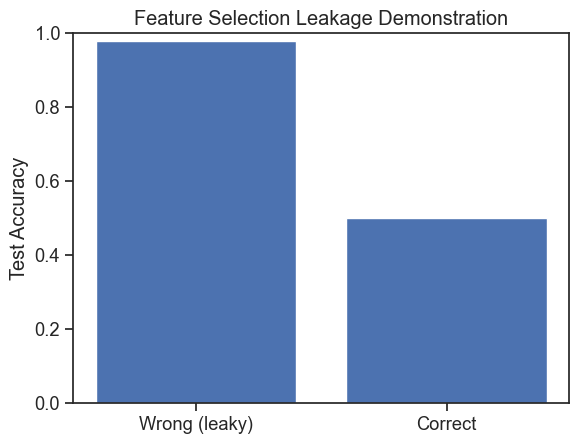

In [154]:
# ------------------------------------------------------------
# feature selection leakage demonstration (gene example)
# ------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# -------------------------
# 1. generate synthetic data
# -------------------------

np.random.seed(0)

n_samples = 120      # number of patients
n_features = 20000   # number of genes (all noise!)

# gene expression: pure noise
X = np.random.normal(size=(n_samples, n_features))

# disease label: random (no relationship to genes)
y = np.random.randint(0, 2, size=n_samples)

# -------------------------
# 2. WRONG approach: feature selection before splitting
# -------------------------

# compute correlation between each gene and the label
correlations = np.array([
    np.corrcoef(X[:, j], y)[0, 1] for j in range(n_features)
])

# select top 50 most correlated genes (using ALL data)
top_k = 50
top_features_wrong = np.argsort(np.abs(correlations))[-top_k:]

X_selected_wrong = X[:, top_features_wrong]

# now split AFTER feature selection (this is the mistake)
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(
    X_selected_wrong, y, test_size=0.4, random_state=42
)

model_wrong = LogisticRegression(max_iter=1000)
model_wrong.fit(X_train_w, y_train_w)

y_pred_w = model_wrong.predict(X_test_w)
acc_wrong = accuracy_score(y_test_w, y_pred_w)

print("WRONG pipeline (feature selection before split)")
print(f"Test accuracy: {acc_wrong:.3f}")
print()

# -------------------------
# 3. CORRECT approach: split first, then select features
# -------------------------

# split raw data first
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42
)

# compute correlations ONLY on training data
correlations_train = np.array([
    np.corrcoef(X_train[:, j], y_train)[0, 1] for j in range(n_features)
])

top_features_correct = np.argsort(np.abs(correlations_train))[-top_k:]

X_train_c = X_train[:, top_features_correct]
X_test_c  = X_test[:, top_features_correct]

model_correct = LogisticRegression(max_iter=1000)
model_correct.fit(X_train_c, y_train)

y_pred_c = model_correct.predict(X_test_c)
acc_correct = accuracy_score(y_test, y_pred_c)

print("CORRECT pipeline (split before feature selection)")
print(f"Test accuracy: {acc_correct:.3f}")
print()

# -------------------------
# 4. visualize comparison
# -------------------------

plt.figure()
plt.bar(["Wrong (leaky)", "Correct"], [acc_wrong, acc_correct])
plt.ylabel("Test Accuracy")
plt.title("Feature Selection Leakage Demonstration")
plt.ylim(0, 1)
plt.show()


## time / sequence dependencies

If your data has a temporal structure, a random split can “expose” future points during training. You can illustrate this with synthetic time series — or even simpler: show that if you shuffle a temporal dataset, the model appears to perform well, but if you respect time order, performance drops.

This is a perfect example of contamination through mishandling the structure of the data

## group leakage

Another subtle case is when units in the data are correlated — e.g., multiple observations from the same subject or cluster — but you split randomly instead of by group. The model ends up trained on data “too similar” to test.

You can illustrate this with a toy example where each group has its own bias — random splits mistakenly allow the model to learn that bias.